In [1]:
from pathlib import Path
from hbond_benchmark.model import Net as HNet
from hbond_benchmark.model import MolData
from molnet_geometric_lightning.model import Net as BaselineNet
from molnet_geometric_lightning.model import MolData as MolDataB
import torch
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
import numpy as np
import pandas as pd

/home/gltyk/miniconda3/envs/mgl/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
name = 'lipo'
gnn = 'gin'
virtual_ = [True, False]


In [3]:
h_ckpts = {}
b_ckpts = {}
for virtual in virtual_:
    h_p = Path(f'/home/gltyk/hbond-benchmark/notebooks/models/{name}/{gnn}/{virtual}/lightning_logs')
    baseline_p = Path(f'/home/gltyk/molnet-geometric-lightning/notebooks/models/{name}/{gnn}/{virtual}/lightning_logs')
    h_ckpts[virtual] = list(h_p.glob('*/*/*.ckpt'))[0]
    b_ckpts[virtual] = list(baseline_p.glob('*/*/*.ckpt'))[0]
    

In [4]:
h_models = {}
b_models = {}
for virtual in virtual_:
    h_models[virtual] = HNet.load_from_checkpoint(
        h_ckpts[virtual],
        task_type='regression',
        h_bonds=True,
        num_tasks=1,
        evaluator=None,
    )
    b_models[virtual] = BaselineNet.load_from_checkpoint(
        b_ckpts[virtual],
        task_type='regression',
        num_tasks=1,
        evaluator=None,
    )
    b_models[virtual].eval();
    h_models[virtual].eval();


In [5]:
data_h = MolData(root='/home/gltyk/hbond-benchmark/notebooks/data', name=name, hydrogen_bonds=True)
data_base = MolDataB(root='/home/gltyk/molnet-geometric-lightning/data', name=name)
data_h.setup(stage='fit')
data_base.setup(stage='fit')

In [6]:
# edge type "HYDROGEN" is encoded as 5
mol_idx_with_hbonds = [int(i) for i in data_h.split_dict['test'] if (data_h.dataset[i].edge_attr == 5).any()]

In [7]:
def get_predictions(model, data_module):
    y_hats = []
    ys = []
    t = data_module.test_dataloader()
    for batch in tqdm(t, total=len(t)):    
        y_hat = model(batch).detach().numpy()
        y = batch.y.detach().numpy()
        y_hats.append(y_hat)
        ys.append(y)

    y_hats = np.concatenate(y_hats)
    ys = np.concatenate(ys)
    return ys, y_hats

In [8]:
h_predictions, b_predictions = {}, {}

for virtual in virtual_:
    y, y_hat_h = get_predictions(h_models[virtual], data_h)
    y, y_hat_b = get_predictions(b_models[virtual], data_base)
    h_predictions[virtual] = y_hat_h
    b_predictions[virtual] = y_hat_b


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.32it/s]


In [12]:
y_hat_h = {}
y_hat_b = {}

for virtual in virtual_:
    s = pd.Series(h_predictions[virtual].ravel(), index=data_h.split_dict['test'].numpy())    
    y_hat_h[virtual] = s


    s = pd.Series(b_predictions[virtual].ravel(), index=data_h.split_dict['test'].numpy())    
    y_hat_b[virtual] = s
    
y = pd.Series(y.ravel(), index=data_h.split_dict['test'].numpy())

In [13]:
result = []

def get_row(model_type, y, y_hat):
    return {
        'type': model_type,
        'r2 overall': r2_score(y, y_hat),
        'r2 has h_bond': r2_score(y[mol_idx_with_hbonds], y_hat[mol_idx_with_hbonds]),
        'r2 no h_bond': r2_score(y.drop(mol_idx_with_hbonds), y_hat.drop(mol_idx_with_hbonds)),
        'rmse overall': np.sqrt(mean_squared_error(y, y_hat)),
        'rmse has h_bond': np.sqrt(mean_squared_error(y[mol_idx_with_hbonds], y_hat[mol_idx_with_hbonds])),
        'rmse no h_bond': np.sqrt(mean_squared_error(y.drop(mol_idx_with_hbonds), y_hat.drop(mol_idx_with_hbonds))),
    }

for virtual in virtual_:
    result.append(get_row(f'hydrogen_{virtual}', y, y_hat_h[virtual]))
    result.append(get_row(f'baseline_{virtual}', y, y_hat_b[virtual]))


In [14]:
pd.DataFrame(result).groupby(['type']).agg('mean').T.round(3)  # for this model only

type,baseline_False,baseline_True,hydrogen_False,hydrogen_True
r2 overall,0.493,0.626,0.560,0.600
r2 has h_bond,0.443,0.588,0.573,0.487
r2 no h_bond,0.501,0.632,0.558,0.619
rmse overall,0.782,0.672,0.729,0.695
rmse has h_bond,0.818,0.703,0.716,0.784
rmse no h_bond,0.776,0.666,0.731,0.678


In [15]:
len(mol_idx_with_hbonds) / len(y)

0.14761904761904762

In [16]:
sh = data_h.dataset[mol_idx_with_hbonds]
sb = data_base.dataset[mol_idx_with_hbonds]

In [17]:
from torch_geometric.data import Batch
from rdkit import Chem

In [18]:
df = pd.DataFrame(
{
    'hydrogen_False': pd.Series(h_predictions[False].ravel(), index=data_h.split_dict['test'].numpy())[mol_idx_with_hbonds],
    'baseline_False': pd.Series(b_predictions[False].ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds],
    
    'hydrogen_True': pd.Series(h_predictions[True].ravel(), index=data_h.split_dict['test'].numpy())[mol_idx_with_hbonds],
    'baseline_True': pd.Series(b_predictions[True].ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds],

    
    'y': pd.Series(y.ravel(), index=data_base.split_dict['test'].numpy())[mol_idx_with_hbonds]
}
)

In [144]:
df[['baseline_True', 'hydrogen_False', 'y']].sort_values('y')[:30]

,baseline_True,hydrogen_False,y
875,-0.232557,-0.174241,-1.30
440,0.912129,0.687331,-0.28
376,0.459209,0.418251,0.47
905,2.483433,2.527539,0.64
515,0.265278,1.604607,0.67
226,0.659202,1.520224,0.70
284,1.328574,1.191846,0.91
510,1.409822,1.800178,1.13
60,2.018500,1.302618,1.19
425,2.009464,1.962209,1.20


In [115]:
pd.DataFrame({'baseline_True_err': abs(df.baseline_True - df.y), 'hydrogen_False_err': abs(df.hydrogen_False - df.y)}).sort_values('hydrogen_False_err')[:30]

,baseline_True_err,hydrogen_False_err
519,0.919735,0.020772
361,0.219153,0.026437
167,0.323968,0.049049
376,0.010791,0.051749
856,0.550203,0.060887
304,1.292284,0.077582
697,0.111401,0.087610
625,0.175597,0.087846
156,0.074510,0.089345
265,0.700554,0.105490


In [489]:
n = 590 # 870 # 284

In [490]:
df.loc[n]

hydrogen_False    1.615935
baseline_False    1.920450
hydrogen_True     0.948458
baseline_True     1.526971
y                 1.200000
Name: 590, dtype: float32

In [491]:
h_models[False](Batch.from_data_list([data_h.dataset[n]]));
b_models[True](Batch.from_data_list([data_base.dataset[n]]));


In [492]:
mol = Chem.MolFromSmiles(data_h.dataset[n].smiles)

In [493]:
from rdkit.Chem.Draw import SimilarityMaps

In [532]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.molSize = 500,500
import matplotlib.pyplot as plt

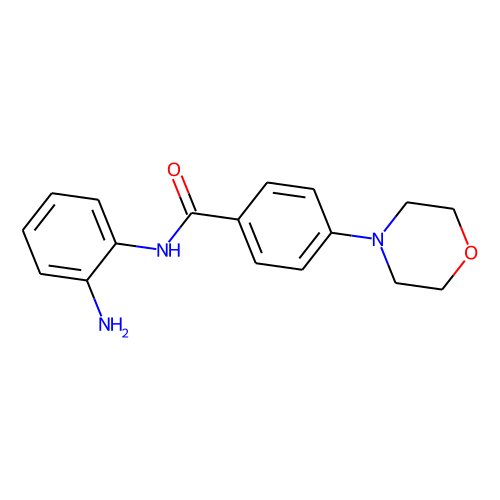

In [533]:
mol

In [534]:
Draw.MolToFile(mol, 'mol_lipo.svg')

In [496]:
# these are the hbonds
data_h.dataset[n].edge_index.T[data_h.dataset[n].edge_attr[:, 0] == 5]

tensor([[0, 7],
        [7, 0]])

(0.0, 1.0, 0.0, 1.0)

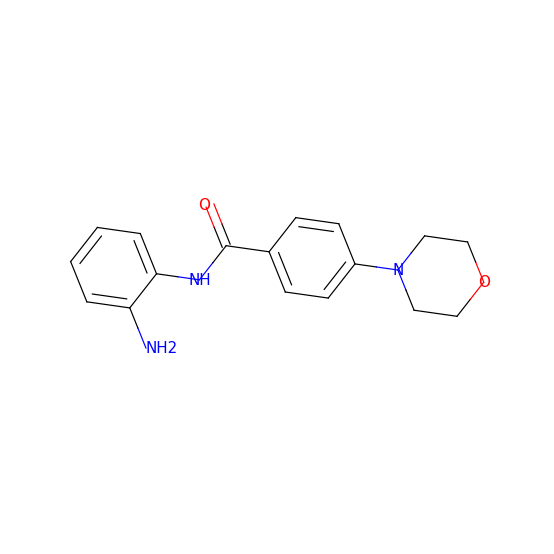

In [497]:
Draw.MolToMPL(mol, axes=False)
plt.axis('off')

# H vs Virt

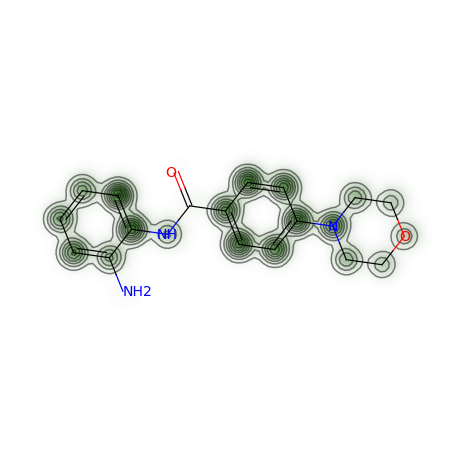

In [498]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, h_models[False].CAM()[0]);

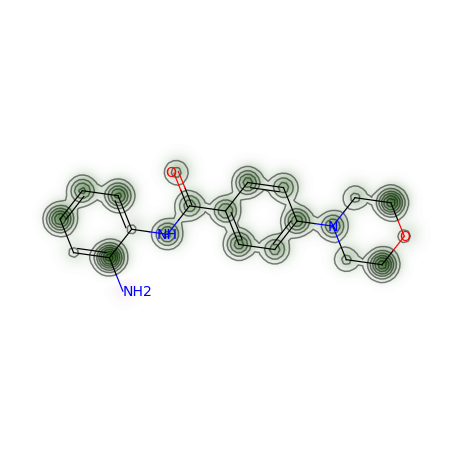

In [524]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, b_models[True].CAM()[0] + 7);

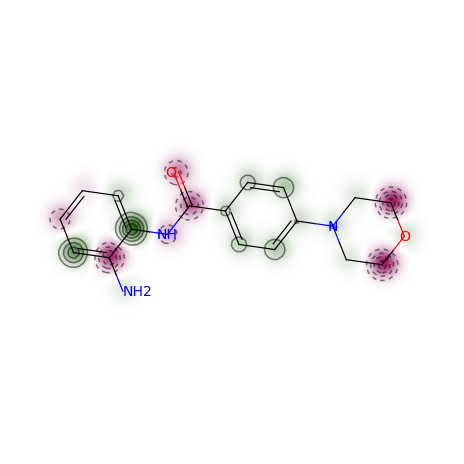

In [525]:
cam_h = h_models[False].CAM()[0]
cam_b = b_models[True].CAM()[0]
SimilarityMaps.GetSimilarityMapFromWeights(
    mol, 
    (cam_h - cam_h.mean()) / cam_h.std() - (cam_b - cam_b.mean()) / cam_b.std(),
);

# H vs Baseline

In [501]:
b_models[False](Batch.from_data_list([data_base.dataset[n]]));

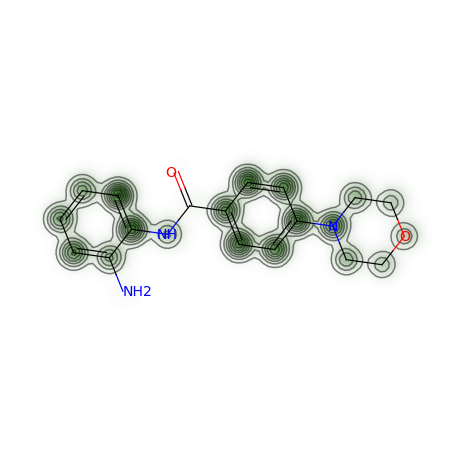

In [508]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, h_models[False].CAM()[0]);

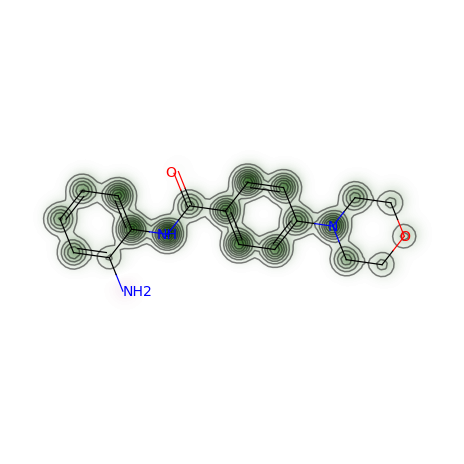

In [509]:
SimilarityMaps.GetSimilarityMapFromWeights(mol, b_models[False].CAM()[0]);

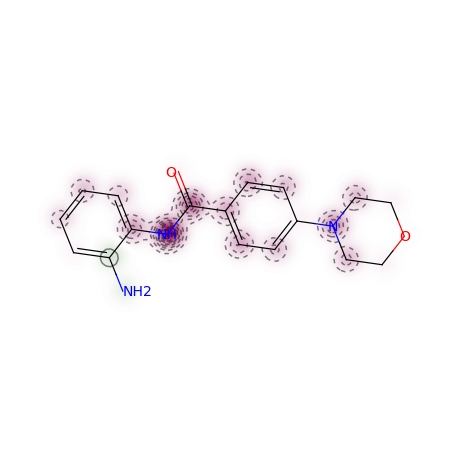

In [510]:
cam_h = h_models[False].CAM()[0]
cam_b = b_models[False].CAM()[0]
SimilarityMaps.GetSimilarityMapFromWeights(
    mol, 
    cam_h - cam_b,
);

In [209]:
def CAM(self, task=0):
    """Get the class attribution mapping for a task"""
    if task >= len(range(self.num_tasks)):
        raise ValueError(f'{task} must be between 0 and {self.num_tasks - 1}')
    task_index = task
    regression_weights = self.graph_pred_linear.weight[task_index].cpu().detach().numpy()
    GAP_like = self.graph_representation.cpu().detach().numpy()
    w = (regression_weights * GAP_like)
    w = w.reshape(1, -1)
    return w @ abs(self.node_representation.cpu().detach().numpy().T)

In [210]:
w = h_models[0].graph_pred_linear.weight.detach().numpy()[0] * h_models[0].graph_representation.detach().numpy()

In [211]:
b_models[0].graph_pred_linear.bias

Parameter containing:
tensor([0.0092], requires_grad=True)

In [469]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='Count'>

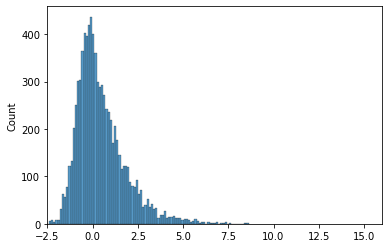

In [470]:
plt.xlim([-2.5, 16])
sns.histplot(h_models[False].node_representation.detach().numpy().ravel(), bins=100)

<AxesSubplot:ylabel='Count'>

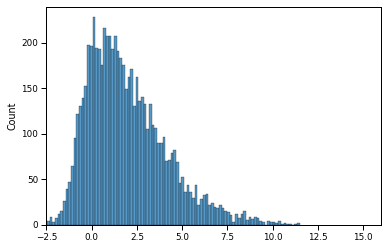

In [535]:
plt.xlim([-2.5, 16])
sns.histplot(b_models[True].node_representation.detach().numpy().ravel(), bins=100)

<AxesSubplot:ylabel='Count'>

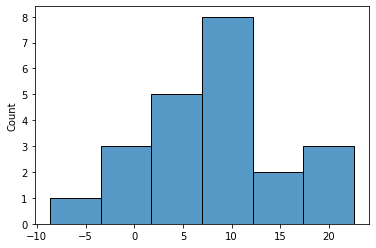

In [511]:
sns.histplot(b_models[True].CAM()[0])

<AxesSubplot:ylabel='Count'>

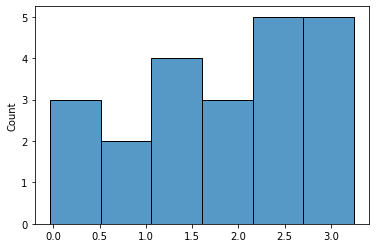

In [512]:
sns.histplot(h_models[False].CAM()[0])

In [526]:
df_nbonds_h = pd.DataFrame(
    [(data_h.dataset[i].edge_attr == 5).sum().item() // 2 for i in data_h.split_dict['test']], index=data_h.split_dict['test'].numpy(), columns=['Num. H-bonds']
)
df_nbonds_v = df_nbonds_h.copy()

In [527]:
df_nbonds_h['Error'] = np.abs(y_hat_h[False] - y)
df_nbonds_h['Model Type'] = 'H-bond'
df_nbonds_v['Error'] = np.abs(y_hat_b[True] - y)
df_nbonds_v['Model Type'] = 'Virt. Node'

In [528]:
df_nbonds = pd.concat([df_nbonds_h, df_nbonds_v])

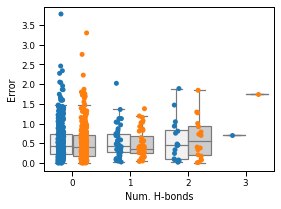

In [531]:
sns.set_context('paper')
plt.figure(figsize=(4, 3))
sns.stripplot(data=df_nbonds[df_nbonds['Num. H-bonds'] <= 3], x='Num. H-bonds', y='Error', hue='Model Type', dodge=True)
g = sns.boxplot(data=df_nbonds[df_nbonds['Num. H-bonds'] <= 3], x='Num. H-bonds', y='Error', hue='Model Type', color=".8", showfliers=False)
g.legend_.remove()
plt.tight_layout()
plt.savefig('lipo_nhbonds.svg')